In [115]:
import math
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.stats import kstest, shapiro
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
%matplotlib inline

In [116]:
def convert_to_float(value):        
    if "K" in value:
        return float(value[:-1]) * 1000
    if "M" in value:
        return float(value[:-1]) * 1000000
    if "B" in value:
        return float(value[:-1]) * 1000000000
    if "%" in value:
        return float(value[:-1]) / 100
    if value == "-":
        return None
    return float(value.replace(",", ""))

In [117]:
def test_normality(data):
    plt.figure(figsize=(6.40, 3.60), dpi=200)
    sb.distplot(data)
    plt.show()
    ks_stat, ks_p = kstest(data, "norm")
    print("Kolmogorov-Smirnov Test Results: ")
    print("Test Statistics = ", ks_stat)
    print("P-value = ", ks_p)
    if ks_p > 0.05:
        print("Probably Gaussian.")
    else:
        print("Not Gausssian.")
    print("------------------------------------------------")
    sh_stat, sh_p = shapiro(data)
    print("Shapiro-Wilk Test Results: ")
    print("Test Statistics = ", sh_stat)
    print("P-value = ", sh_p)
    if sh_p > 0.05:
        print("Probably Gaussian.")
    else:
        print("Not Gausssian.")    

In [118]:
def plot(data_label_pairs, x_label, y_label, title):
    plt.figure(figsize=(6.40, 3.60), dpi=200)
    for data, label in data_label_pairs:
        plt.plot(data, label=label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [119]:
def prepare_for_lstm(data, look_back):
    data_x, data_y = [], []
    for i in range(len(data) - look_back):
        data_window = data[i:i + look_back]
        data_x.append(data_window)
        data_y.append(data[i + look_back])
    return np.array(data_x), np.array(data_y)

In [120]:
def performance(actual, predicted):
    print("Performance:")
    mse = mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    print("mean squared error: ", mse)
    print("root mean square error: ", rmse)
    print("mean absolute error: ", mae)
    print("mean absolute percentage error: ", mape, "%")

In [121]:
ether_data = pd.read_csv("Datasets/ETH-USD-Data.csv")
ether_data.rename(columns={"Price": "Close", "Vol.": "Volume", "Change %": "Change"}, inplace=True)
ether_data["Date"] = ether_data['Date'].astype("datetime64")
for column in ether_data.columns[1:]:
    ether_data[column] = ether_data[column].apply(convert_to_float)
ether_data = ether_data.reindex(columns=["Date", "Open", "High", "Low", "Close", "Volume", "Change"]).set_index("Date").sort_values("Date")
ether_data.interpolate(inplace=True)
dates = list(ether_data.index)

In [122]:
ether_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2252 non-null   float64
 1   High    2252 non-null   float64
 2   Low     2252 non-null   float64
 3   Close   2252 non-null   float64
 4   Volume  2252 non-null   float64
 5   Change  2252 non-null   float64
dtypes: float64(6)
memory usage: 123.2 KB


In [123]:
ether_data.describe()

,Open,High,Low,Close,Volume,Change
count,2252.000000,2252.000000,2252.000000,2252.000000,2.252000e+03,2252.000000
mean,812.901239,841.363615,780.354378,813.961607,1.323084e+07,0.003973
std,1163.234596,1199.773415,1120.483259,1163.604697,1.037117e+08,0.056057
min,6.680000,7.320000,5.860000,6.700000,0.000000e+00,-0.445500
25%,135.372500,139.487500,130.700000,135.460000,5.336425e+05,-0.022300
50%,258.000000,268.905000,242.690000,258.900000,1.480000e+06,0.001100
75%,754.400000,798.180000,719.557500,759.147500,7.942500e+06,0.029425
max,4808.340000,4864.060000,4715.430000,4808.380000,1.790000e+09,0.295100


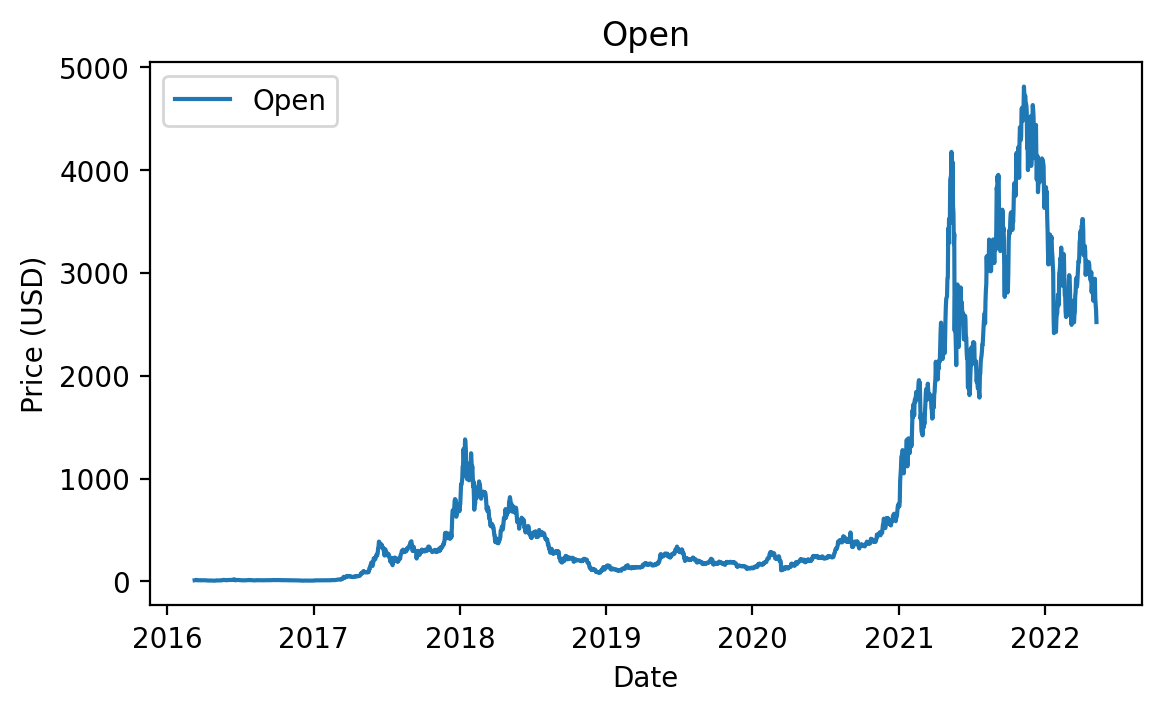

In [124]:
plot(data_label_pairs=[(ether_data["Open"], "Open")], x_label="Date", y_label="Price (USD)", title="Open")

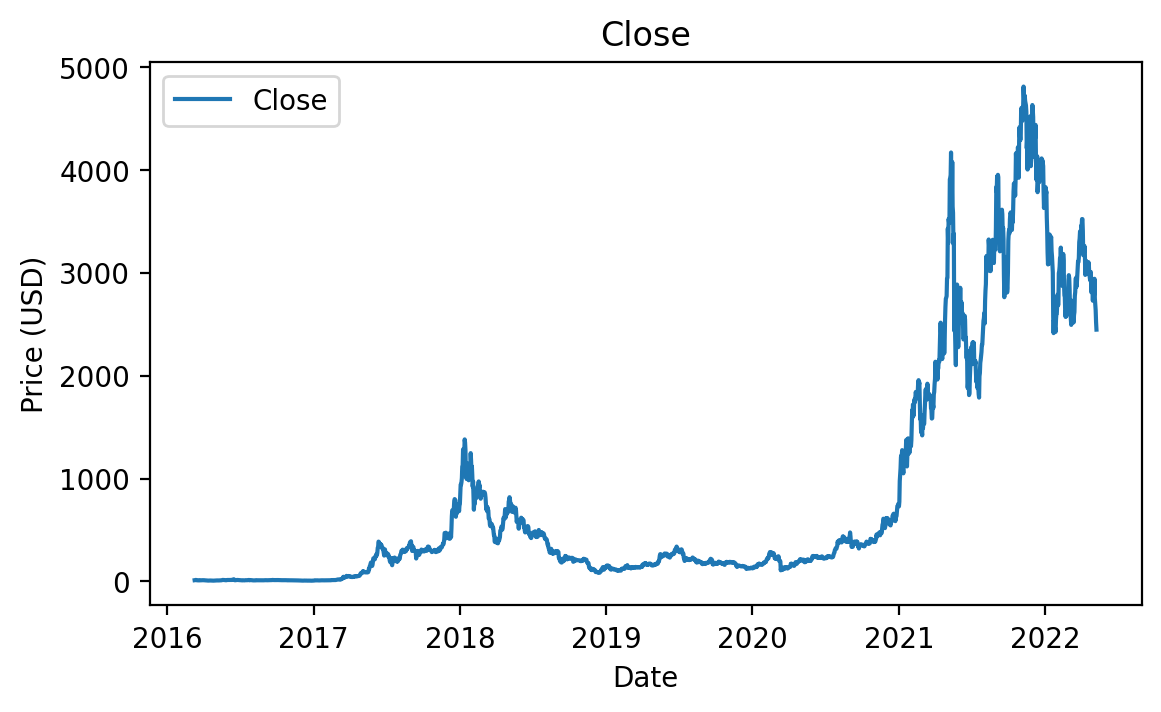

In [125]:
plot(data_label_pairs=[(ether_data["Close"], "Close")], x_label="Date", y_label="Price (USD)", title="Close")

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


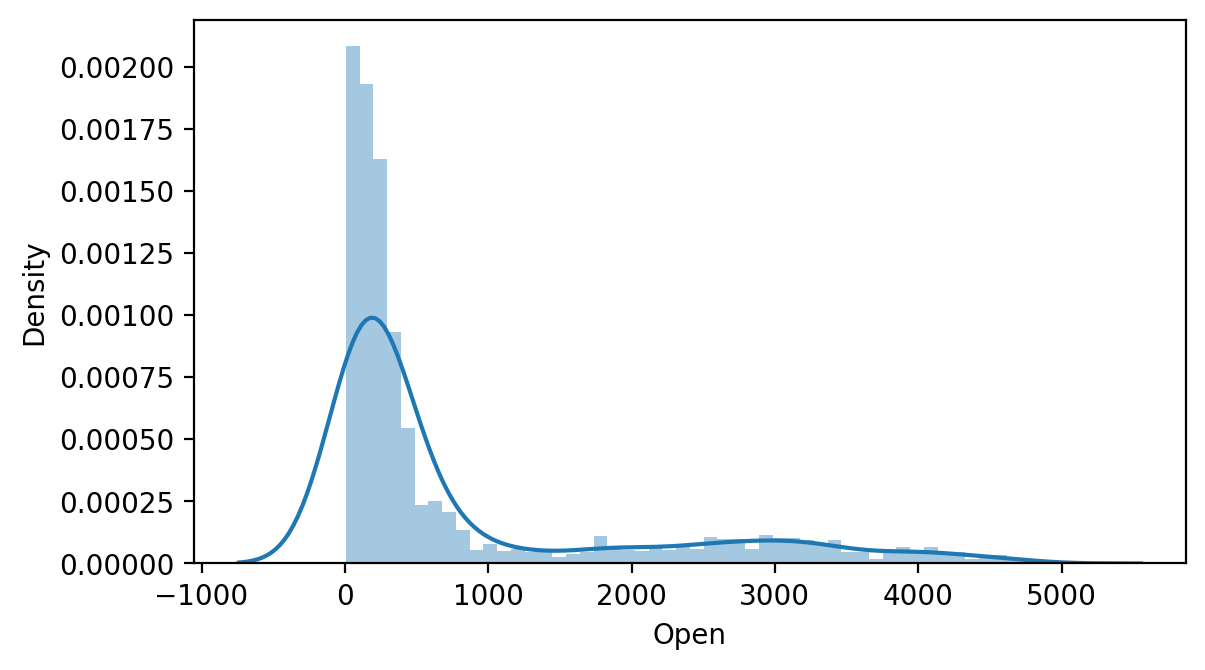

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.9999999999880529
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.6839131116867065
P-value =  0.0
Not Gausssian.


In [126]:
test_normality(ether_data["Open"])

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


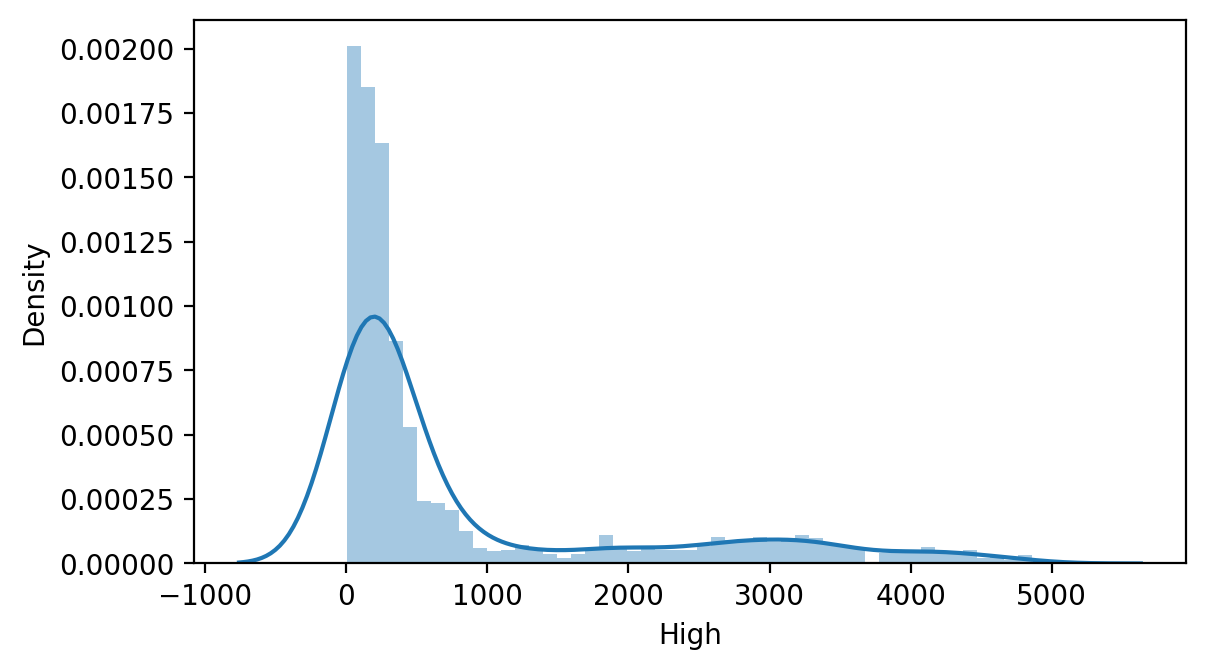

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.999999999999876
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.685326099395752
P-value =  0.0
Not Gausssian.


In [127]:
test_normality(ether_data["High"])

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


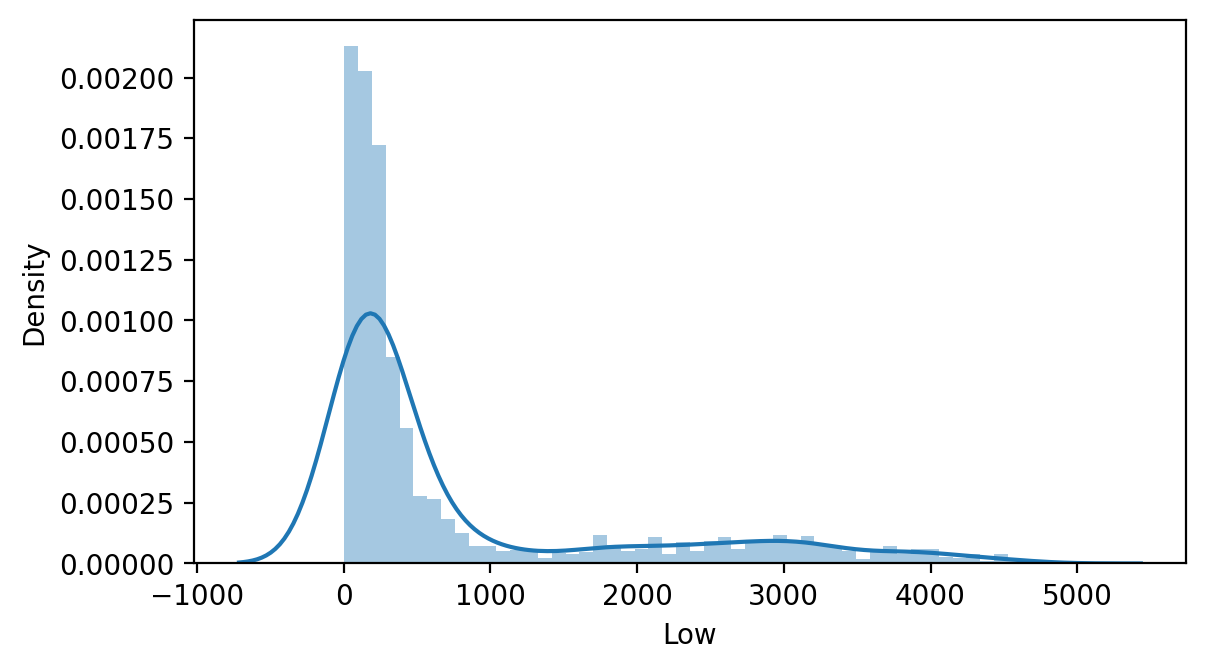

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.9999999976856642
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.6821624040603638
P-value =  0.0
Not Gausssian.


In [128]:
test_normality(ether_data["Low"])

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


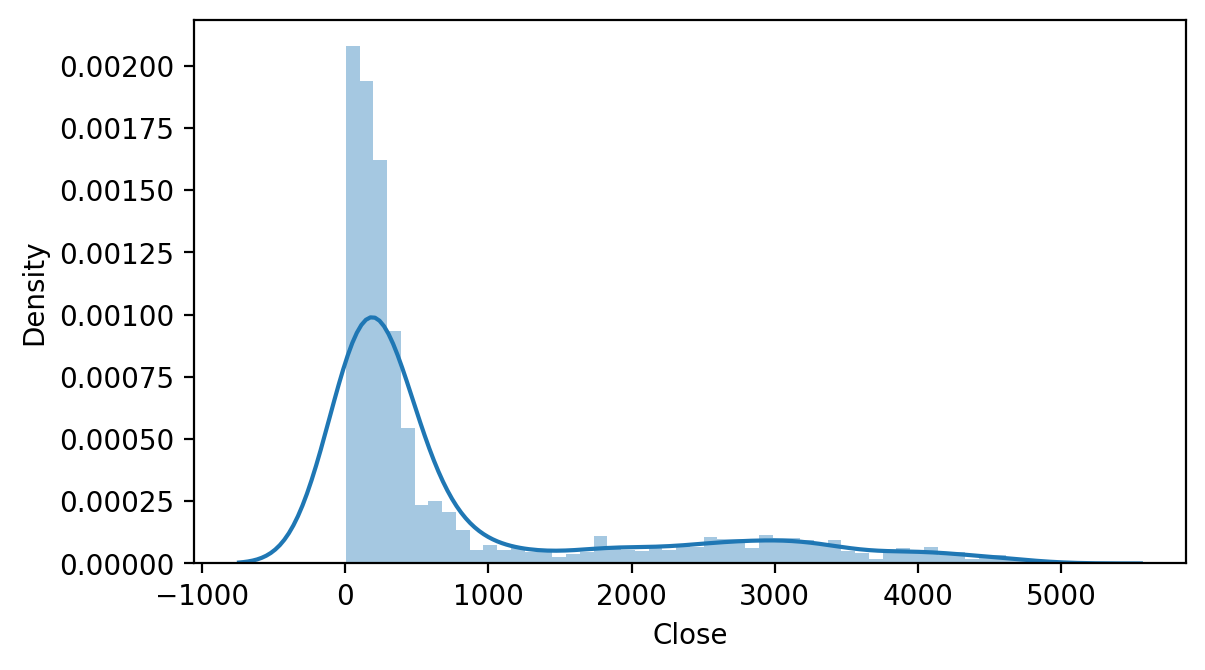

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.999999999989579
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.6844182014465332
P-value =  0.0
Not Gausssian.


In [129]:
test_normality(ether_data['Close'])

In [130]:
ether_data_uni = pd.DataFrame(ether_data, columns=["Close"])

In [131]:
ether_data_uni

,Close
Date,
2016-03-10,11.75
2016-03-11,11.95
2016-03-12,12.92
2016-03-13,15.07
2016-03-14,12.50
...,...
2022-05-05,2747.46
2022-05-06,2692.88
2022-05-07,2636.03


In [132]:
ether_data_uni.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2252 non-null   float64
dtypes: float64(1)
memory usage: 35.2 KB


In [133]:
ether_data_uni.describe()

,Close
count,2252.000000
mean,813.961607
std,1163.604697
min,6.700000
25%,135.460000
50%,258.900000
75%,759.147500
max,4808.380000


In [134]:
uni_training_size = int(len(ether_data_uni) * 0.90)
uni_test_size = len(ether_data_uni) - uni_training_size
train_ether_uni = ether_data_uni[:uni_training_size]
test_ether_uni = ether_data_uni[uni_training_size:]

In [135]:
train_ether_uni

,Close
Date,
2016-03-10,11.75
2016-03-11,11.95
2016-03-12,12.92
2016-03-13,15.07
2016-03-14,12.50
...,...
2021-09-21,2761.52
2021-09-22,3077.78
2021-09-23,3152.92


In [136]:
test_ether_uni

,Close
Date,
2021-09-26,3063.51
2021-09-27,2926.24
2021-09-28,2807.28
2021-09-29,2851.50
2021-09-30,3000.59
...,...
2022-05-05,2747.46
2022-05-06,2692.88
2022-05-07,2636.03


In [137]:
# standard_scaler = StandardScaler()
# scaled_train_uni = standard_scaler.fit_transform(train_ether_uni)
# scaled_test_uni = standard_scaler.fit_transform(test_ether_uni)
minmax_scaler = MinMaxScaler()
scaled_train_uni = minmax_scaler.fit_transform(train_ether_uni)
scaled_test_uni = minmax_scaler.fit_transform(test_ether_uni)

In [138]:
scaled_train_uni.shape

(2026, 1)

In [139]:
scaled_test_uni.shape

(226, 1)

In [140]:
uni_train_x, uni_train_y = prepare_for_lstm(scaled_train_uni, 3)
uni_test_x, uni_test_y = prepare_for_lstm(scaled_test_uni, 3)
uni_train_x = uni_train_x.reshape((-1, uni_train_x.shape[1], 1))
uni_test_x = uni_test_x.reshape((-1, uni_test_x.shape[1], 1))

In [141]:
# inversed_actual = standard_scaler.inverse_transform(uni_test_y.reshape(-1, uni_test_y.shape[1]))
inversed_actual = minmax_scaler.inverse_transform(uni_test_y.reshape(-1, uni_test_y.shape[1]))
actual_uni = pd.DataFrame(data=inversed_actual, index=dates[-1 * len(inversed_actual):], columns=["Close"])
actual_uni.index.name = "Date"

In [142]:
uni_train_x.shape, uni_train_y.shape

((2023, 3, 1), (2023, 1))

In [143]:
uni_test_x.shape, uni_test_y.shape

((223, 3, 1), (223, 1))

In [144]:
actual_uni

,Close
Date,
2021-09-29,2851.50
2021-09-30,3000.59
2021-10-01,3309.13
2021-10-02,3388.97
2021-10-03,3417.34
...,...
2022-05-05,2747.46
2022-05-06,2692.88
2022-05-07,2636.03


In [145]:
vanilla_model = tf.keras.models.Sequential()
vanilla_model.add(tf.keras.layers.LSTM(units=128, activation="relu", input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
vanilla_model.add(tf.keras.layers.Dense(units=1))
vanilla_model.summary()
vanilla_model.compile(optimizer="adam", loss="mse")
vanilla_results = vanilla_model.fit(uni_train_x, uni_train_y, epochs=50, verbose=1, validation_data=(uni_test_x, uni_test_y))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 128)               66560     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
64/64 [==============================] - 2s 8ms/step - loss: 0.0168 - val_loss: 0.0053
Epoch 2/50
64/64 [==============================] - 0s 3ms/step - loss: 3.9197e-04 - val_loss: 0.0048
Epoch 3/50
64/64 [==============================] - 0s 3ms/step - loss: 2.8999e-04 - val_loss: 0.0047
Epoch 4/50
64/64 [==============================] - 0s 5ms/step - loss: 2.9942e-04 - val_loss: 0.0047
Epoch 5/50
64/64 [========================

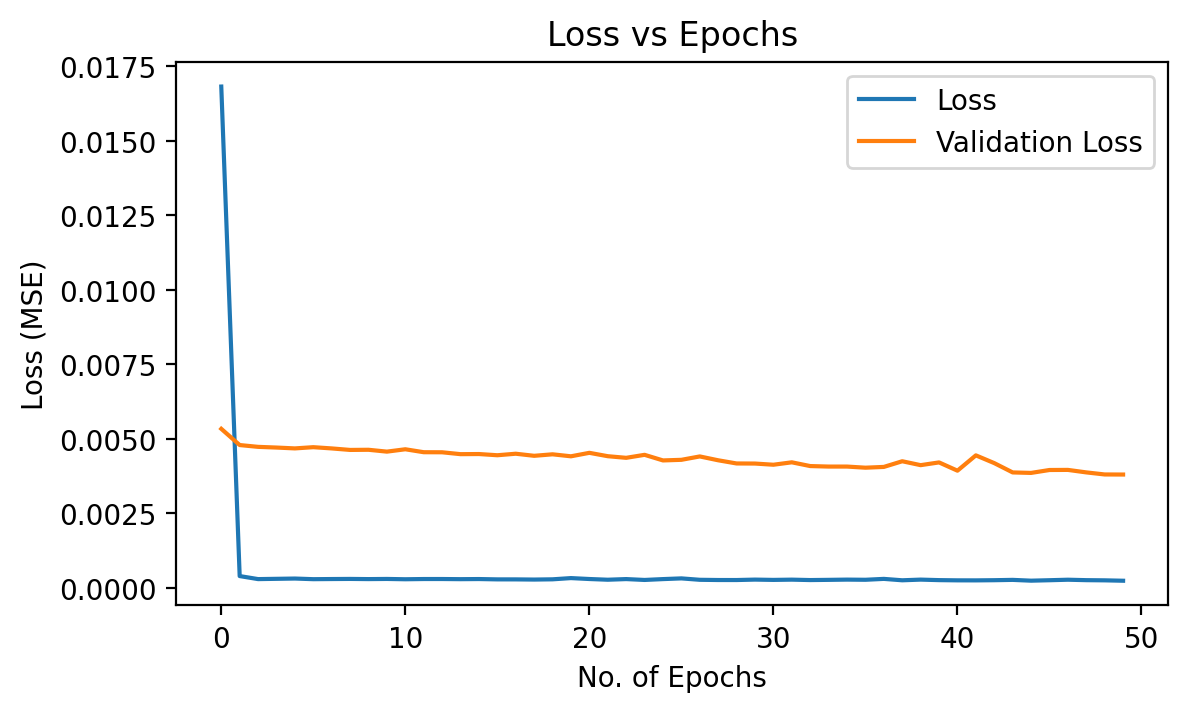

In [146]:
plot(data_label_pairs=[(vanilla_results.history["loss"], "Loss"), (vanilla_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [147]:
# predicted_vanilla =  pd.DataFrame(data=standard_scaler.inverse_transform(vanilla_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_vanilla =  pd.DataFrame(data=minmax_scaler.inverse_transform(vanilla_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_vanilla.index.name = "Date"

In [148]:
predicted_vanilla

,Predicted_Close
Date,
2021-09-29,2914.985596
2021-09-30,2867.837402
2021-10-01,2925.748291
2021-10-02,3134.252441
2021-10-03,3322.057617
...,...
2022-05-05,2884.549072
2022-05-06,2833.768799
2022-05-07,2776.414307


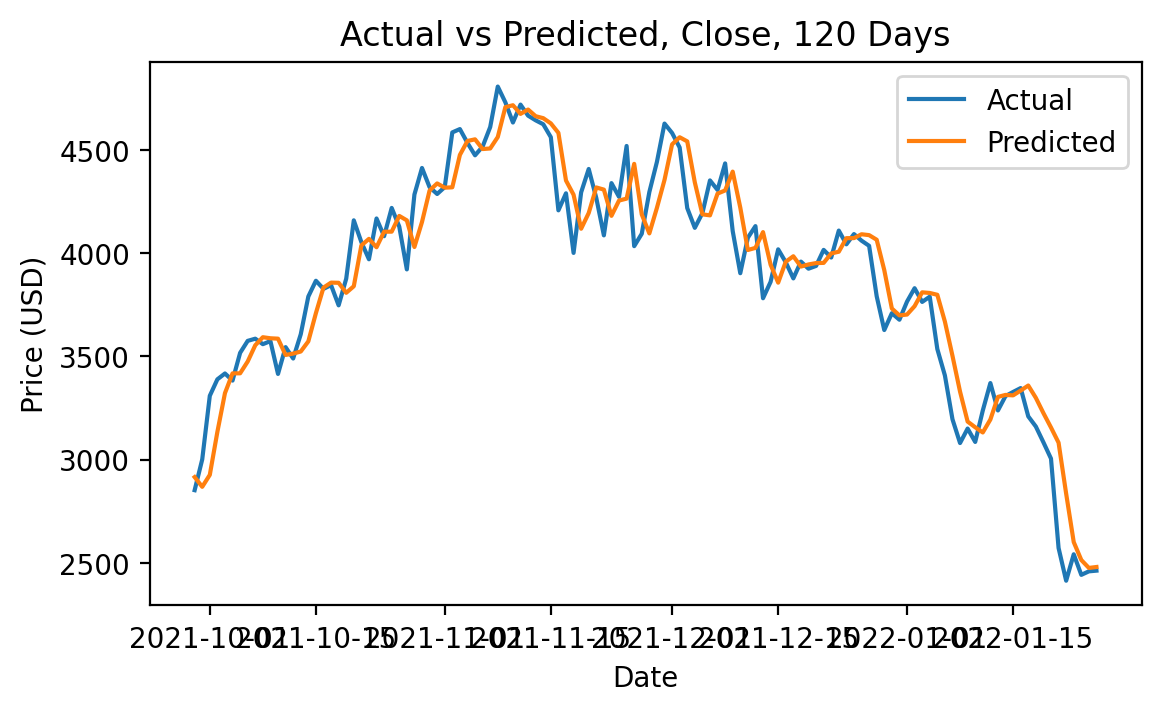

In [149]:
plot(data_label_pairs=[(actual_uni["Close"][:120], "Actual"), (predicted_vanilla["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [150]:
performance(actual_uni["Close"][:120], predicted_vanilla["Predicted_Close"][:120])

Performance:
mean squared error:  27637.551786674823
root mean square error:  166.2454564391906
mean absolute error:  122.69941088867185
mean absolute percentage error:  3.297076703620536 %


In [151]:
stacked_model = tf.keras.models.Sequential()
stacked_model.add(tf.keras.layers.LSTM(units=128, activation="relu", return_sequences=True,  input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
stacked_model.add(tf.keras.layers.LSTM(units=64, activation="relu"))
stacked_model.add(tf.keras.layers.Dense(units=1))
stacked_model.summary()
stacked_model.compile(optimizer="adam", loss="mse")
stacked_results = stacked_model.fit(uni_train_x, uni_train_y, epochs=50, verbose=1, validation_data=(uni_test_x, uni_test_y))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 3, 128)            66560     
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
64/64 [==============================] - 3s 12ms/step - loss: 0.0206 - val_loss: 0.0128
Epoch 2/50
64/64 [==============================] - 0s 4ms/step - loss: 5.8369e-04 - val_loss: 0.0061
Epoch 3/50
64/64 [==============================] - 0s 4ms/step - loss: 4.2790e-04 - val_loss: 0.0075
Epoch 4/5

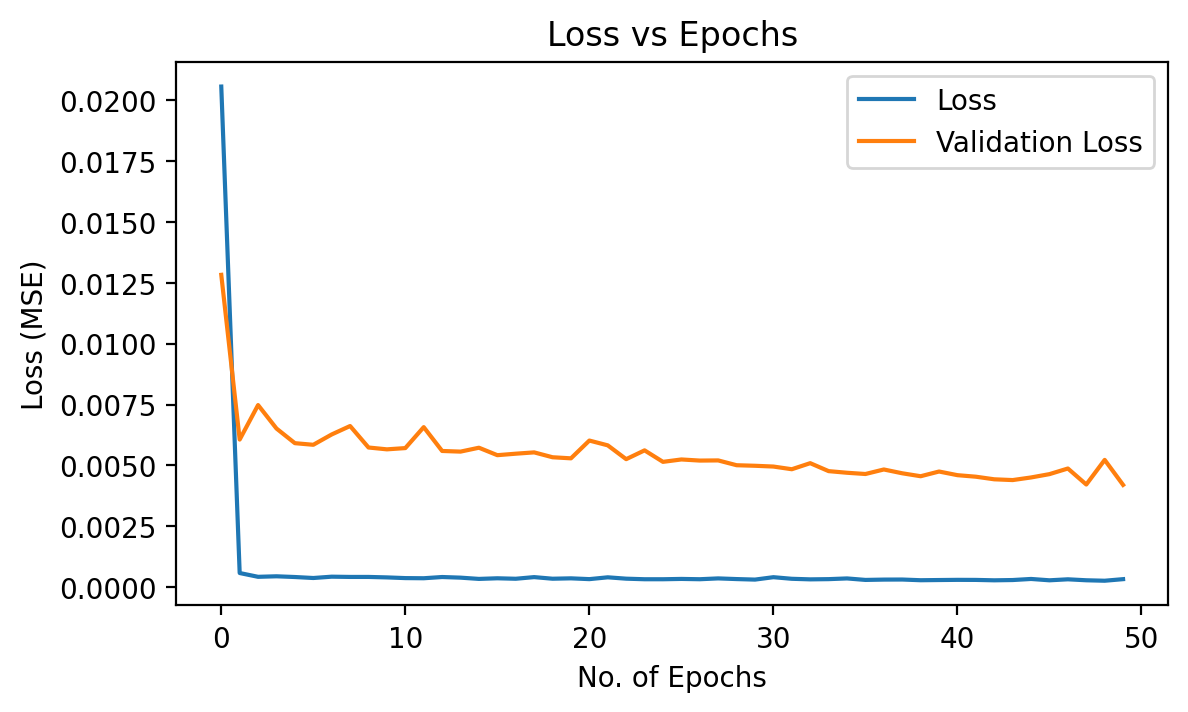

In [152]:
plot(data_label_pairs=[(stacked_results.history["loss"], "Loss"), (stacked_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [153]:
# predicted_stacked =  pd.DataFrame(data=standard_scaler.inverse_transform(stacked_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_stacked =  pd.DataFrame(data=minmax_scaler.inverse_transform(stacked_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_stacked.index.name = "Date"

In [154]:
predicted_stacked

,Predicted_Close
Date,
2021-09-29,2950.062500
2021-09-30,2879.453369
2021-10-01,2904.873291
2021-10-02,3080.195068
2021-10-03,3286.521973
...,...
2022-05-05,2874.962891
2022-05-06,2851.516113
2022-05-07,2812.661377


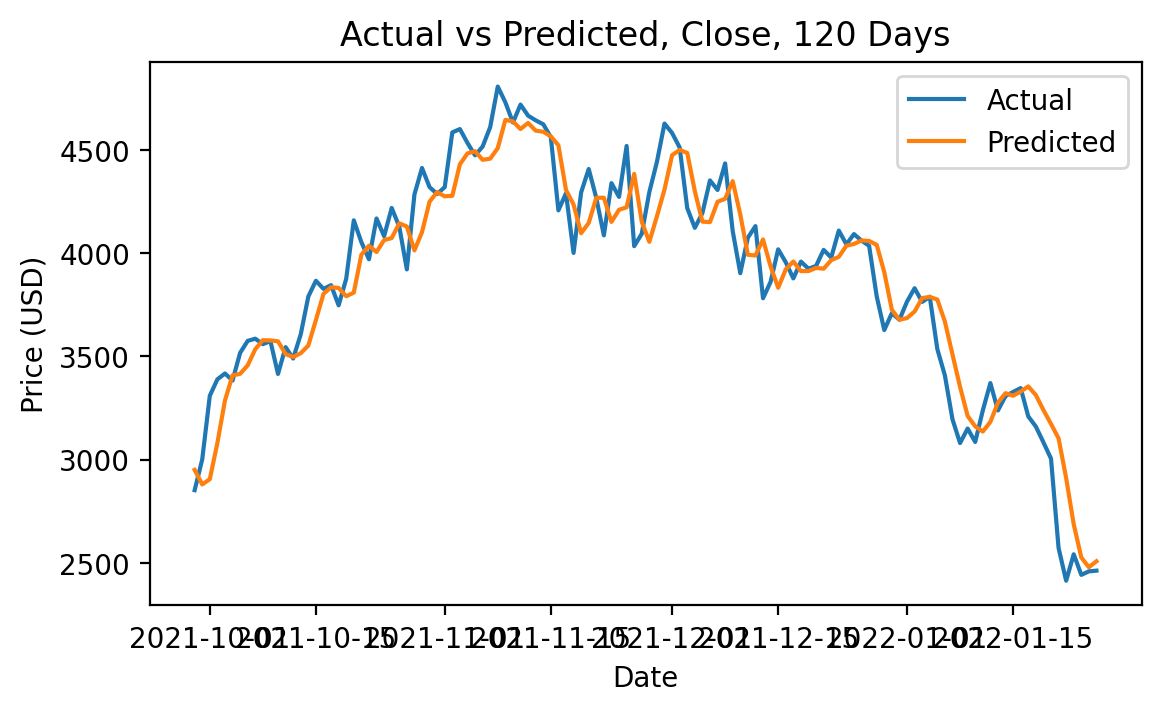

In [155]:
plot(data_label_pairs=[(actual_uni["Close"][:120], "Actual"), (predicted_stacked["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [156]:
performance(actual_uni, predicted_stacked)

Performance:
mean squared error:  24110.425840461157
root mean square error:  155.27532270280798
mean absolute error:  119.74539561729257
mean absolute percentage error:  3.6228340670879886 %


In [157]:
bidirectional_model = tf.keras.models.Sequential()
bidirectional_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, activation="sigmoid"), input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
bidirectional_model.add(tf.keras.layers.Dense(units=1))
bidirectional_model.summary()
bidirectional_model.compile(optimizer="adam", loss="mse")
bidirectional_results = bidirectional_model.fit(uni_train_x, uni_train_y, batch_size=256, epochs=30, verbose=1, validation_data=(uni_test_x, uni_test_y))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 256)              133120    
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
8/8 [==============================] - 2s 64ms/step - loss: 0.0454 - val_loss: 0.1957
Epoch 2/30
8/8 [==============================] - 0s 17ms/step - loss: 0.0332 - val_loss: 0.1607
Epoch 3/30
8/8 [==============================] - 0s 22ms/step - loss: 0.0298 - val_loss: 0.1117
Epoch 4/30
8/8 [==============================] - 0s 20ms/step - loss: 0.0268 - val_los

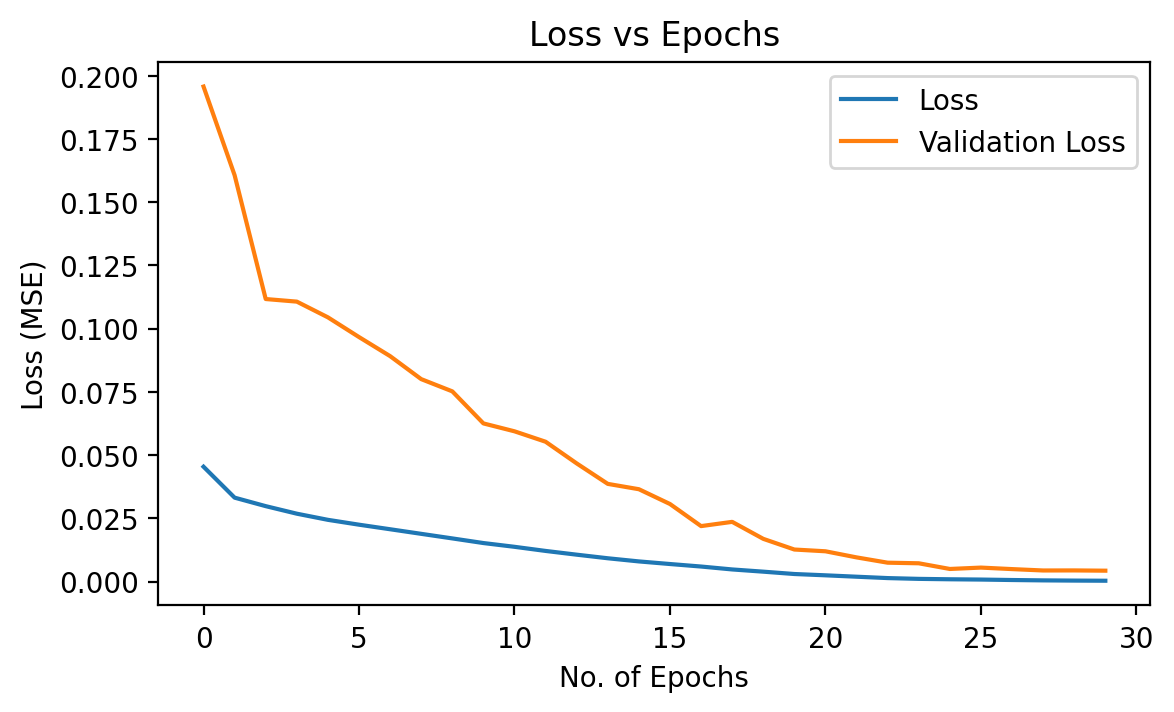

In [158]:
plot(data_label_pairs=[(bidirectional_results.history["loss"], "Loss"), (bidirectional_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [159]:
# predicted_bidirectional =  pd.DataFrame(data=standard_scaler.inverse_transform(bidirectional_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_bidirectional =  pd.DataFrame(data=minmax_scaler.inverse_transform(bidirectional_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_bidirectional.index.name = "Date"

In [160]:
predicted_bidirectional

,Predicted_Close
Date,
2021-09-29,2927.287598
2021-09-30,2869.649414
2021-10-01,2894.840332
2021-10-02,3065.439941
2021-10-03,3216.661865
...,...
2022-05-05,2874.086426
2022-05-06,2803.099365
2022-05-07,2799.063965


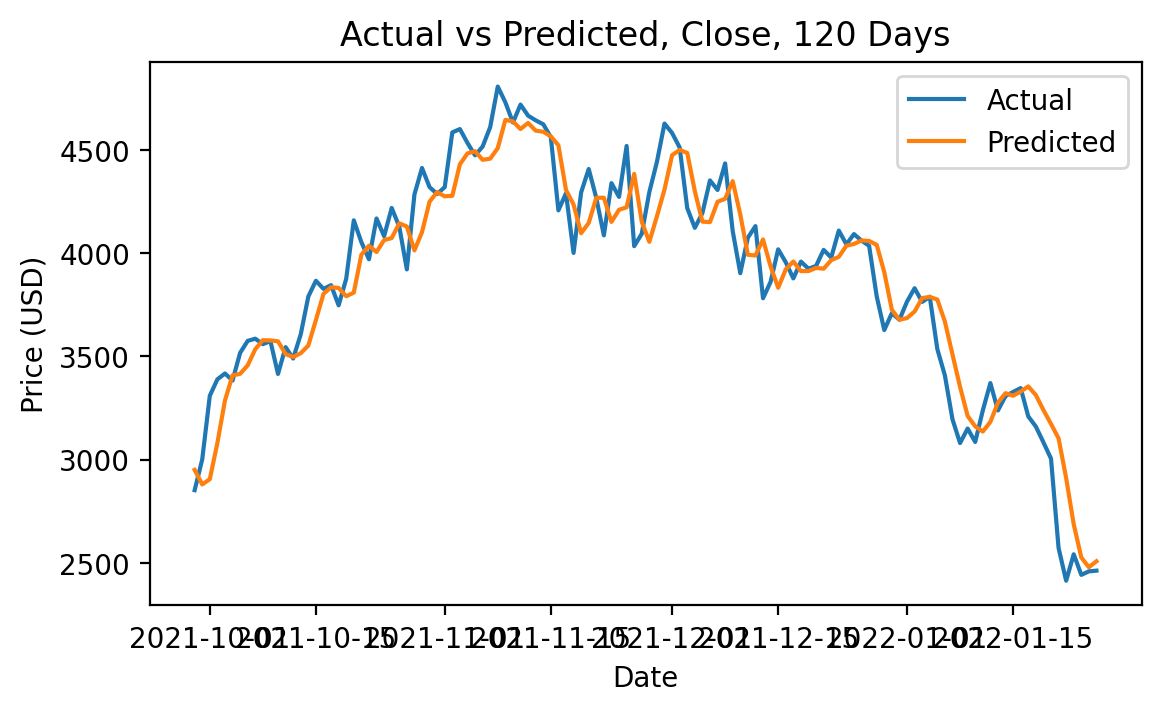

In [161]:
plot(data_label_pairs=[(actual_uni["Close"][:120], "Actual"), (predicted_stacked["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [162]:
performance(actual_uni, predicted_bidirectional)

Performance:
mean squared error:  24547.973471323396
root mean square error:  156.67792911359084
mean absolute error:  122.61220979014854
mean absolute percentage error:  3.6520666053679105 %


In [163]:
ether_data.corr()

,Open,High,Low,Close,Volume,Change
Open,1.000000,0.999374,0.998569,0.998238,0.104588,-0.032946
High,0.999374,1.000000,0.998477,0.999155,0.104855,-0.017002
Low,0.998569,0.998477,1.000000,0.999118,0.106389,-0.012295
Close,0.998238,0.999155,0.999118,1.000000,0.105243,0.000184
Volume,0.104588,0.104855,0.106389,0.105243,1.000000,0.000230
Change,-0.032946,-0.017002,-0.012295,0.000184,0.000230,1.000000


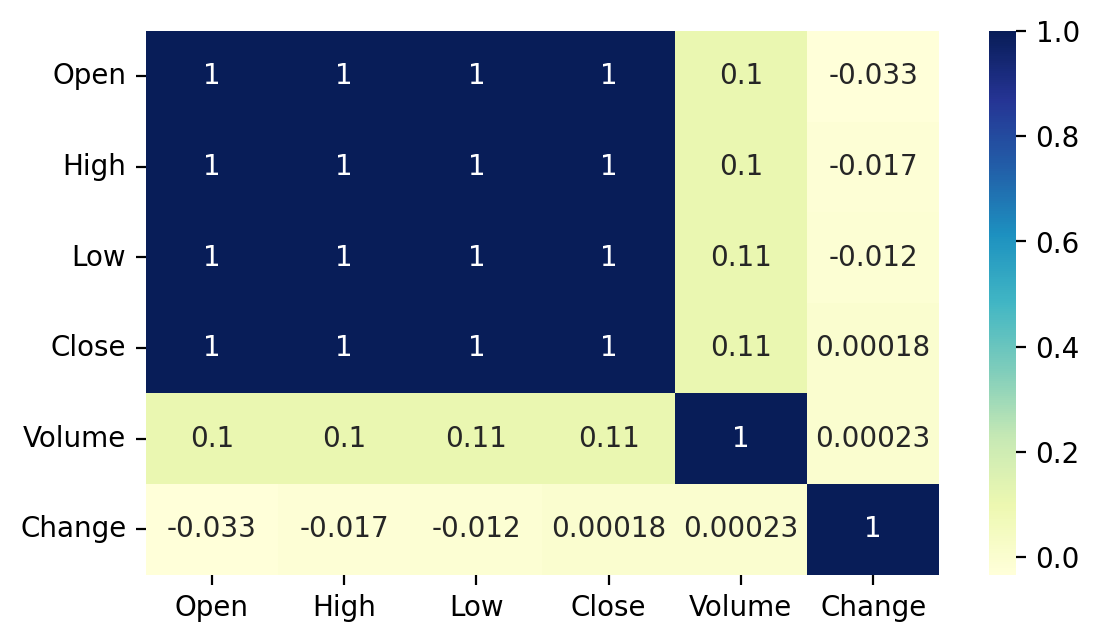

In [164]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
sb.heatmap(ether_data.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [165]:
ether_data_multi = pd.DataFrame(ether_data, columns=["Open", "High", "Low", "Close"])

In [166]:
ether_data_multi

,Open,High,Low,Close
Date,,,,
2016-03-10,11.20,11.85,11.07,11.75
2016-03-11,11.75,11.95,11.75,11.95
2016-03-12,11.95,13.45,11.95,12.92
2016-03-13,12.92,15.07,12.92,15.07
2016-03-14,15.07,15.07,11.40,12.50
...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46
2022-05-06,2747.60,2757.14,2635.85,2692.88
2022-05-07,2692.92,2703.11,2589.29,2636.03


In [167]:
ether_data_multi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2252 non-null   float64
 1   High    2252 non-null   float64
 2   Low     2252 non-null   float64
 3   Close   2252 non-null   float64
dtypes: float64(4)
memory usage: 88.0 KB


In [168]:
ether_data_multi.describe()

,Open,High,Low,Close
count,2252.000000,2252.000000,2252.000000,2252.000000
mean,812.901239,841.363615,780.354378,813.961607
std,1163.234596,1199.773415,1120.483259,1163.604697
min,6.680000,7.320000,5.860000,6.700000
25%,135.372500,139.487500,130.700000,135.460000
50%,258.000000,268.905000,242.690000,258.900000
75%,754.400000,798.180000,719.557500,759.147500
max,4808.340000,4864.060000,4715.430000,4808.380000


In [169]:
multi_training_size = int(len(ether_data_multi) * 0.90)
multi_test_size = len(ether_data_multi) - multi_training_size
train_ether_multi = ether_data_multi[:multi_training_size]
test_ether_multi = ether_data_multi[multi_training_size:]

In [170]:
train_ether_multi

,Open,High,Low,Close
Date,,,,
2016-03-10,11.20,11.85,11.07,11.75
2016-03-11,11.75,11.95,11.75,11.95
2016-03-12,11.95,13.45,11.95,12.92
2016-03-13,12.92,15.07,12.92,15.07
2016-03-14,15.07,15.07,11.40,12.50
...,...,...,...,...
2021-09-21,2976.70,3101.88,2659.71,2761.52
2021-09-22,2764.71,3087.97,2740.58,3077.78
2021-09-23,3077.80,3173.00,3035.96,3152.92


In [171]:
test_ether_multi

,Open,High,Low,Close
Date,,,,
2021-09-26,2922.47,3113.65,2740.12,3063.51
2021-09-27,3061.86,3163.86,2926.24,2926.24
2021-09-28,2926.04,2969.18,2791.42,2807.28
2021-09-29,2807.15,2948.50,2784.66,2851.50
2021-09-30,2851.06,3047.08,2837.68,3000.59
...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46
2022-05-06,2747.60,2757.14,2635.85,2692.88
2022-05-07,2692.92,2703.11,2589.29,2636.03


In [172]:
# standard_scaler_multi = StandardScaler()
# scaled_train_multi = standard_scaler_multi.fit_transform(train_ether_multi)
# scaled_test_multi = standard_scaler_multi.fit_transform(test_ether_multi)
minmax_scaler_multi = MinMaxScaler()
scaled_train_multi = minmax_scaler_multi.fit_transform(train_ether_multi)
scaled_test_multi = minmax_scaler_multi.fit_transform(test_ether_multi)

In [173]:
scaled_train_multi.shape

(2026, 4)

In [174]:
scaled_test_multi.shape

(226, 4)

In [175]:
multi_train_x, multi_train_y = prepare_for_lstm(scaled_train_multi, 5)
multi_test_x, multi_test_y = prepare_for_lstm(scaled_test_multi, 5)

In [176]:
multi_train_x.shape, multi_train_y.shape

((2021, 5, 4), (2021, 4))

In [177]:
multi_test_x.shape, multi_test_y.shape

((221, 5, 4), (221, 4))

In [178]:
# inversed_actual_multi = standard_scaler_multi.inverse_transform(uni_test_y.reshape(-1, uni_test_y.shape[1]))
inversed_actual_multi = minmax_scaler_multi.inverse_transform(multi_test_y)
actual_multi = pd.DataFrame(data=inversed_actual_multi, index=dates[-1 * len(inversed_actual_multi):], columns=["Open", "High", "Low", "Close"])
actual_multi.index.name = "Date"

In [179]:
actual_multi

,Open,High,Low,Close
Date,,,,
2021-10-01,2999.86,3329.32,2972.75,3309.13
2021-10-02,3309.14,3467.95,3265.97,3388.97
2021-10-03,3388.83,3485.48,3346.63,3417.34
2021-10-04,3417.26,3436.34,3273.22,3382.90
2021-10-05,3383.32,3540.83,3365.28,3517.26
...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46
2022-05-06,2747.60,2757.14,2635.85,2692.88
2022-05-07,2692.92,2703.11,2589.29,2636.03


In [180]:
multi_model = tf.keras.models.Sequential()
multi_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, activation="sigmoid", return_sequences=True), input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.5))
multi_model.add(tf.keras.layers.LSTM(units=64, return_sequences=True, input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.4))
multi_model.add(tf.keras.layers.LSTM(units=32, return_sequences=True, input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.3))
multi_model.add(tf.keras.layers.LSTM(units=16, input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.2))
multi_model.add(tf.keras.layers.Dense(units=multi_train_x.shape[2]))
multi_model.summary()
multi_model.compile(optimizer="adam", loss="mse")
multi_results = multi_model.fit(multi_train_x, multi_train_y, batch_size=256, epochs=12, verbose=1, validation_data=(multi_test_x, multi_test_y))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 5, 256)           136192    
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 5, 256)            0         
                                                                 
 lstm_20 (LSTM)              (None, 5, 64)             82176     
                                                                 
 dropout_9 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_21 (LSTM)              (None, 5, 32)             12416     
                                                                 
 dropout_10 (Dropout)        (None, 5, 32)             0         
                                                     

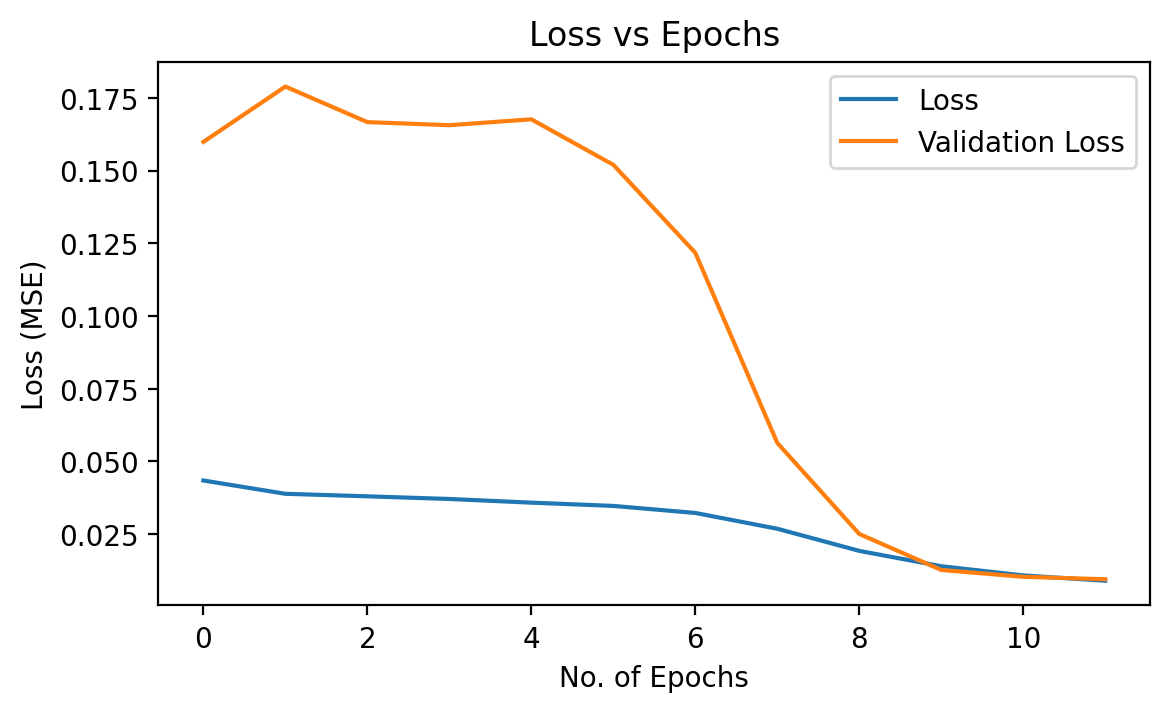

In [181]:
plot(data_label_pairs=[(multi_results.history["loss"], "Loss"), (multi_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [182]:
# predicted_multi =  pd.DataFrame(data=standard_scaler_multi.inverse_transform(multi_model.predict(multi_test_x)), index=dates[-1 * len(inversed_actual_multi):], columns=["Predicted_Open", "Predicted_High", "Predicted_Low", "Predicted_Close"])
predicted_multi =  pd.DataFrame(data=minmax_scaler_multi.inverse_transform(multi_model.predict(multi_test_x)), index=dates[-1 * len(inversed_actual_multi):], columns=["Predicted_Open", "Predicted_High", "Predicted_Low", "Predicted_Close"])
predicted_vanilla.index.name = "Date"

In [183]:
predicted_multi

,Predicted_Open,Predicted_High,Predicted_Low,Predicted_Close
2021-10-01,2868.957275,2940.524170,2630.150879,2837.325684
2021-10-02,2875.293213,2943.727051,2631.760986,2843.592773
2021-10-03,2917.562012,2974.257324,2660.757324,2882.853760
2021-10-04,3057.875488,3098.990479,2797.959473,3009.395264
2021-10-05,3250.517578,3280.167236,2999.495605,3183.835205
...,...,...,...,...
2022-05-05,2740.042969,2818.859375,2487.893066,2723.743408
2022-05-06,2755.395752,2833.063477,2504.214844,2737.284424
2022-05-07,2758.142334,2837.555176,2510.521484,2739.407471
2022-05-08,2736.616943,2819.930420,2491.508057,2720.109863


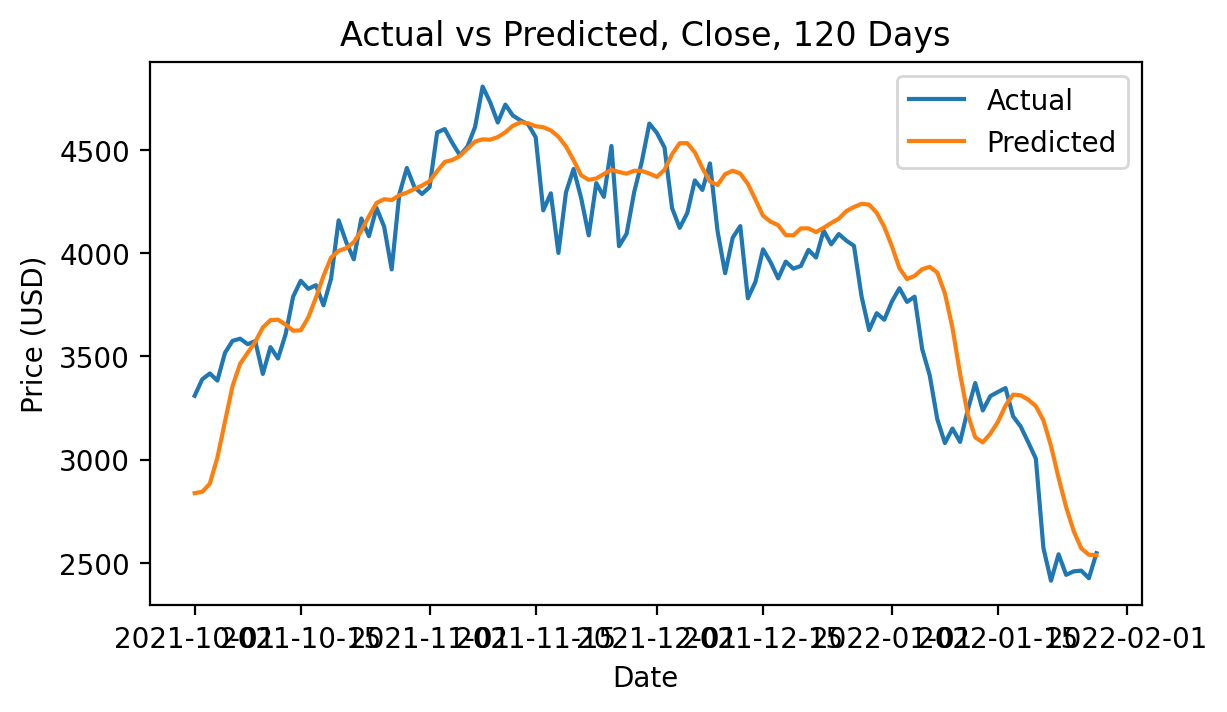

In [184]:
plot(data_label_pairs=[(actual_multi["Close"][:120], "Actual"), (predicted_multi["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [185]:
performance(actual_multi["Close"], predicted_multi["Predicted_Close"])

Performance:
mean squared error:  55777.1057251901
root mean square error:  236.17177165188497
mean absolute error:  182.94529464790722
mean absolute percentage error:  5.528199988360553 %
